In [155]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics

In [156]:

train_df = pd.read_csv('train.csv', dtype={'Age': np.float64},)
titanic_df = pd.read_csv('test.csv', dtype={'Age': np.float64},)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [157]:

# delete unused columns
train_df = train_df.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)
titanic_df = titanic_df.drop(['Name','Ticket', 'Cabin'], axis=1)

In [158]:
train_df["Embarked"] = train_df['Embarked'].fillna("S")

embark_prec = train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

embark_dummys_train = pd.get_dummies(train_df['Embarked'])
embark_dummys_train.drop(['S'], axis=1, inplace=True)

embark_dummys_test = pd.get_dummies(titanic_df['Embarked'])
embark_dummys_test.drop(['S'], axis=1, inplace=True)

train_df = train_df.join(embark_dummys_train)
titanic_df = titanic_df.join(embark_dummys_test)

train_df.drop(['Embarked'], axis=1, inplace=True)
titanic_df.drop(['Embarked'], axis=1, inplace=True)

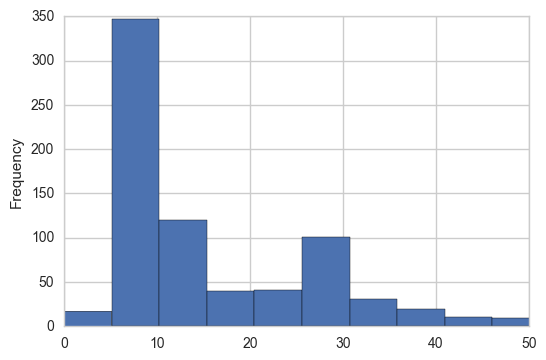

In [159]:
titanic_df['Fare'].fillna(titanic_df['Fare'].median(), inplace=True)

train_df['Fare'] = train_df['Fare'].astype(int)
titanic_df['Fare'] = titanic_df['Fare'].astype(int)

fare_not_survived = train_df['Fare'][train_df['Survived'] == 0]
fare_survived = train_df['Fare'][train_df['Survived'] == 1]

train_df['Fare'].plot(kind='hist', bins=100, xlim=(0, 50))

In [160]:
# treating Age
average_age_train = train_df['Age'].mean()
std_age_train = train_df['Age'].std()
count_na_age_train = train_df['Age'].isnull().sum()

average_age_test = titanic_df['Age'].mean()
std_age_test = titanic_df['Age'].std()
count_na_age_test = titanic_df['Age'].isnull().sum()

print count_na_age_test

# generating random age
rand1 = np.random.randint(average_age_train-std_age_train, average_age_train+std_age_train, size=count_na_age_train)
rand2 = np.random.randint(average_age_test-std_age_test, average_age_test+std_age_test, size=count_na_age_test)

# replacing NA and generated age values in age column
train_df['Age'][np.isnan(train_df['Age'])] = rand1
titanic_df['Age'][np.isnan(titanic_df['Age'])] = rand2

train_df['Age'] = train_df['Age'].astype(int)
titanic_df['Age'] = titanic_df['Age'].astype(int)

86


C:\Users\bannu\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\bannu\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[<matplotlib.text.Text at 0x164073c8>, <matplotlib.text.Text at 0x163fa400>]

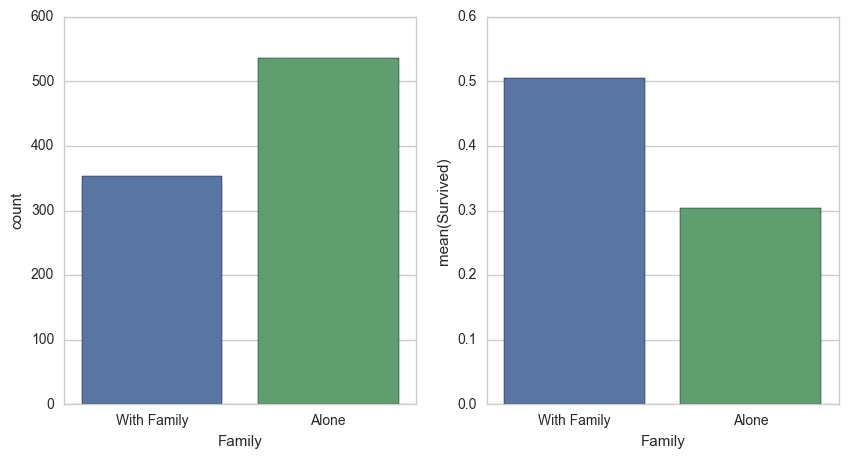

In [161]:
train_df['Family'] =  train_df["Parch"] + train_df["SibSp"]
train_df['Family'].loc[train_df['Family'] > 0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0

titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

# drop Parch & SibSp
train_df = train_df.drop(['SibSp','Parch'], axis=1)
titanic_df   = titanic_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))


sns.countplot(x='Family', data=train_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = train_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

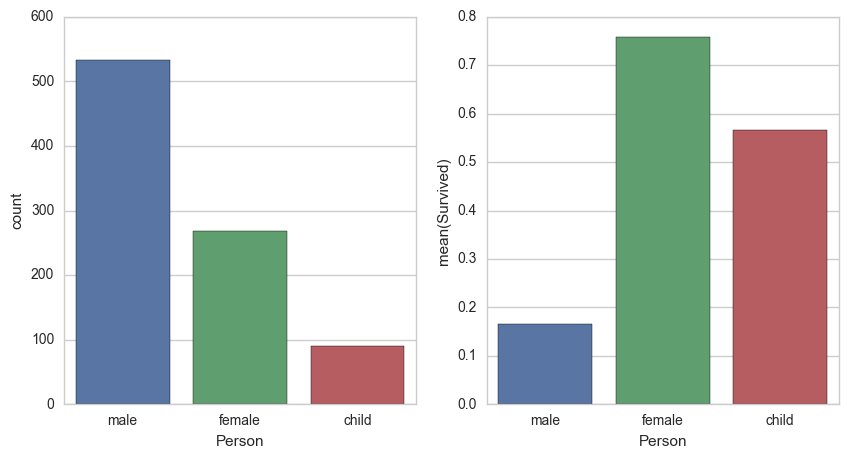

In [162]:
#"children and women first" rule application
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train_df['Person'] = train_df[['Age','Sex']].apply(get_person,axis=1)
titanic_df['Person']    = titanic_df[['Age','Sex']].apply(get_person,axis=1)

train_df.drop(['Sex'],axis=1,inplace=True)
titanic_df.drop(['Sex'],axis=1,inplace=True)


person_dummies_train  = pd.get_dummies(train_df['Person'])
person_dummies_train.columns = ['Male','Female','Child']
person_dummies_train.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(titanic_df['Person'])
person_dummies_test.columns = ['Male','Female','Child']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

train_df = train_df.join(person_dummies_train)
titanic_df   = titanic_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='Person', data=train_df, ax=axis1)

family_perc = train_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=family_perc, ax=axis2, order=['male','female','child'])

train_df.drop(['Person'],axis=1,inplace=True)
titanic_df.drop(['Person'],axis=1,inplace=True)

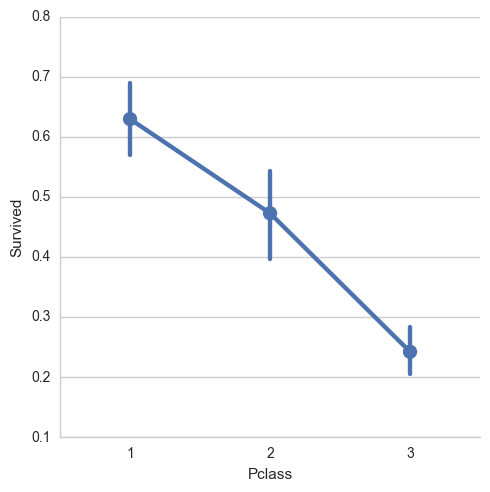

In [163]:
# Passengerclass

sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_df,size=5)


pclass_dummies_train = pd.get_dummies(train_df['Pclass'])
pclass_dummies_train.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_train.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train_df.drop(['Pclass'],axis=1,inplace=True)
titanic_df.drop(['Pclass'],axis=1,inplace=True)

train_df = train_df.join(pclass_dummies_train)
titanic_df    = titanic_df.join(pclass_dummies_test)

In [150]:
X_train = train_df.drop(['Survived'], axis=1)
Y_train = train_df['Survived']
X_test = titanic_df.drop(['PassengerId'], axis=1).copy()

In [151]:
X_train

,Age,Fare,C,Q,Family,Female,Child,Class_1,Class_2
0,22,7,0.0,0.0,1,0.0,1.0,0.0,0.0
1,38,71,1.0,0.0,1,1.0,0.0,1.0,0.0
2,26,7,0.0,0.0,0,1.0,0.0,0.0,0.0
3,35,53,0.0,0.0,1,1.0,0.0,1.0,0.0
4,35,8,0.0,0.0,0,0.0,1.0,0.0,0.0
5,36,8,0.0,1.0,0,0.0,1.0,0.0,0.0
6,54,51,0.0,0.0,0,0.0,1.0,1.0,0.0
7,2,21,0.0,0.0,1,0.0,0.0,0.0,0.0
8,27,11,0.0,0.0,1,1.0,0.0,0.0,0.0
9,14,30,1.0,0.0,1,0.0,0.0,0.0,1.0


In [152]:
Y_train

0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, dtype: int64

In [153]:
X_test

,Age,Fare,C,Q,Family,Female,Child,Class_1,Class_2
0,34,7,0.0,1.0,0,0.0,1.0,0.0,0.0
1,47,7,0.0,0.0,1,1.0,0.0,0.0,0.0
2,62,9,0.0,1.0,0,0.0,1.0,0.0,1.0
3,27,8,0.0,0.0,0,0.0,1.0,0.0,0.0
4,22,12,0.0,0.0,1,1.0,0.0,0.0,0.0
5,14,9,0.0,0.0,0,0.0,0.0,0.0,0.0
6,30,7,0.0,1.0,0,1.0,0.0,0.0,0.0
7,26,29,0.0,0.0,1,0.0,1.0,0.0,1.0
8,18,7,1.0,0.0,0,1.0,0.0,0.0,0.0
9,21,24,0.0,0.0,1,0.0,1.0,0.0,0.0
